In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# シード
seed = 408
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
class Transform():
    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.8, 1.0), ratio=(4/5, 5/4)),
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.ToTensor()
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.ToTensor()
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [5]:
def make_datapath_list():
    rootpath = '../images/Resized_64/'
    target_path = rootpath + '*/*.jpg'
    print(target_path)
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [6]:
class FaceDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path[21:25]
        
        label = self.label_judge(label)
        
        return img_transformed, label
        
    def label_judge(self, label):
        if label == 'ryoo':
            label = 0
        elif label == 'shin':
            label = 1
        elif label == 'koki':
            label = 2
        elif label == 'koji':
            label = 3
        elif label == 'riku':
            label= 4
        elif label == 'othe':
            label = 5
        return label
    

In [7]:
path_list = make_datapath_list()
path_train, path_val = train_test_split(path_list, test_size=0.2)
size = 64
transform = Transform(size)

../images/Resized_64/*/*.jpg


In [8]:
size = 64
transform = Transform(size)
img_transformed = transform(img, phase='train')
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

NameError: name 'img' is not defined

torch.Size([3, 64, 64])


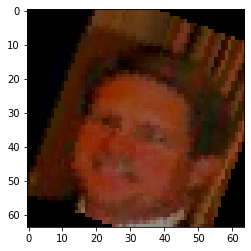

5


In [10]:
train_dataset = FaceDataset(path_train, Transform(size), phase='train')
val_dataset = FaceDataset(path_val, Transform(size), phase='val')
index = 0
print(train_dataset.__getitem__(0)[0].size())
transformed_img = train_dataset.__getitem__(index)[0]
transformed_img = transformed_img.numpy().transpose((1, 2, 0))
plt.imshow(transformed_img)
plt.show()
print(train_dataset.__getitem__(index)[1])

In [11]:
# ミニバッチサイズ
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 64, 64])
tensor([2, 2, 0, 0, 3, 1, 2, 5, 4, 3, 5, 2, 1, 4, 5, 2, 5, 5, 2, 0, 1, 5, 1, 4,
        2, 0, 4, 0, 2, 3, 5, 0])


In [12]:
class EaseClassificationModel(nn.Module):

    def __init__(self, H, W):
        super(EaseClassificationModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128 * (H//4) * (W//4), 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

In [19]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('---------------')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in dataloaders_dict[phase]:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs,labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとの結果の計算
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [20]:
model = EaseClassificationModel(size, size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
num_epochs = 3
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 1/3
---------------
train Loss: 1.7406 Acc: 0.3019
val Loss: 1.7490 Acc: 0.2946
Epoch 2/3
---------------
train Loss: 1.7391 Acc: 0.3045
val Loss: 1.7490 Acc: 0.2946
Epoch 3/3
---------------


KeyboardInterrupt: 